In [6]:
import torch
from torch import nn
import torch.optim as optim

# CNN 모듈 (위/경도 처리)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 10 * 7, 128)  # Input을 적절히 Flatten하여 Linear Layer에 전달
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers
        x = self.pool(self.relu(self.conv1(x)))  # (N, 1, 43, 28) -> (N, 32, 21, 14)
        x = self.pool(self.relu(self.conv2(x)))  # (N, 32, 21, 14) -> (N, 64, 10, 7)

        # Flatten the output of the conv layers
        x = x.view(-1, 64 * 10 * 7)  # Flatten: (N, 64, 10, 7) -> (N, 64 * 10 * 7)

        # Fully connected layer
        x = self.relu(self.fc1(x))  # (N, 64 * 10 * 7) -> (N, 128)
        return x

# MLP 모듈 (정형 데이터 처리: 금리, 면적 등)
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 96)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = x.squeeze(1)
        return x

# 결합 모델 (CNN + MLP)
class CombinedModel(nn.Module):
    def __init__(self, input_size):
        super(CombinedModel, self).__init__()
        self.cnn = CNNModel()
        self.mlp = MLPModel(input_size)
        self.fc = nn.Linear(128+96, 1)  # CNN과 MLP의 출력 크기를 합친 후 최종 예측

    def forward(self, x_cnn, x_mlp):
        cnn_out = self.cnn(x_cnn)  # CNN 처리 (위/경도)
        mlp_out = self.mlp(x_mlp)  # MLP 처리 (정형 데이터)

        combined = torch.cat((cnn_out, mlp_out), dim=1)  # 두 출력을 결합

        out = self.fc(combined)  # 최종 예측 (전세가)
        return out

In [13]:
from utils.datasets import *
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

def train(model, train_loader, loss_fn, optimizer, epochs, device, losses):

    # train 모드로 설정
    model.train()

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for batch in tqdm(train_loader):
            X_cnn,X_mlp, y = batch
            X_cnn, X_mlp, y = X_cnn.to(device), X_mlp.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X_cnn, X_mlp)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

def validate(model, valid_loader, device) -> int:
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            X_cnn, X_mlp, y = batch
            X_cnn, X_mlp, y = X_cnn.to(device), X_mlp.to(device), y.to(device)
            
            output = model(X_cnn, X_mlp)
            
            # 예측값을 numpy로 변환하고 (batch_size, 1) 형태로 조정 후 리스트에 저장
            all_preds.append(output.cpu().numpy().reshape(-1, 1))
            all_targets.append(y.cpu().numpy().reshape(-1, 1))  # 실제값도 같은 형태로 저장

    # 전체 데이터를 (len(valid), 1) 형태의 numpy 배열로 변환
    all_preds = np.vstack(all_preds)  # 세로로 쌓아서 (len(valid), 1) 배열 생성
    all_targets = np.vstack(all_targets)  # 실제값도 같은 방식으로 변환
    print(all_preds)
    # MAE 계산
    mae_score = mean_absolute_error(all_targets, all_preds)
    print(f'\nMAE Score: {mae_score:.4f}')
    return mae_score

def inference_test(model, test_loader, device) -> np.ndarray:
    model.to(device)
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            X_cnn, X_mlp = batch
            X_cnn, X_mlp = X_cnn.to(device), X_mlp.to(device)

            y_pred = model(X_cnn, X_mlp)
            all_preds.append(y_pred.cpu().numpy().reshape(-1,1))
            
        output = np.array(np.vstack(all_preds))

    return output



In [ ]:
from utils.datasets import CombinedDataset
from torch.utils.data import DataLoader

train_set = CombinedDataset(mode='train')
valid_set = CombinedDataset(mode='valid')
test_set = CombinedDataset(mode='test')

train_loader = DataLoader(dataset=train_set, batch_size = 64, shuffle=False)
valid_loader = DataLoader(dataset=valid_set, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

In [11]:
mlp_input = len(valid_set.mlp[0][0][0])
print("feature 수 : ", mlp_input)

# batch 단위로 학습
device = 'cuda'

#model = CombinedModel(mlp_input).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
losses = []

feature 수 :  36


In [ ]:
train(model = model, train_loader= train_loader, loss_fn = criterion, optimizer = optimizer, epochs = epochs, device = device, losses = losses)

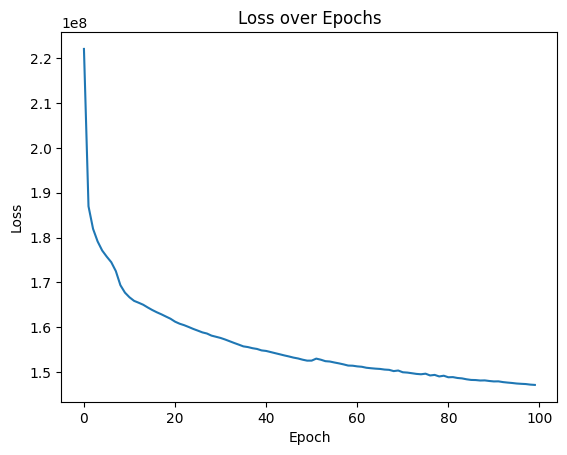

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [25]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [1]:
from utils import datasets

valid_set = datasets.CombinedDataset(mode='valid')
test_set = datasets.CombinedDataset(mode='test')

valid_set[0]

198549it [00:16, 11957.54it/s]
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/preprocessing.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(map_dict).astype('category')


start to feature engineering...
create clustering features


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clusteri

create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.
standardization...


150172it [00:12, 12242.61it/s]
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)


clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/preprocessing.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(map_dict).astype('category')


start to feature engineering...
create clustering features


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clusteri

create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.
standardization...


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[-1.7320e+00,  1.0708e+00,  1.5443e+00, -4.3475e-01,  1.7160e+00,
           3.7200e+01,  1.2682e+02, -1.5438e+00,  1.5937e+00, -2.1885e+00,
           2.9295e+00,  1.4210e+00,  4.4390e+00, -1.7149e-01, -2.2506e-01,
          -7.3803e-01,  6.9722e-01,  3.5435e-01,  5.1388e+00, -5.6122e-01,
          -8.6457e-01, -1.5878e+00, -1.6628e+00, -1.3995e+00, -1.3064e+00,
          -8.6370e-01, -1.2134e+00,  8.6794e-01,  6.3246e-02,  4.6643e-01,
          -5.6533e-01,  5.3678e-01,  8.3514e-01,  1.3196e+00, -4.4565e-01,
          -4.6090e-01]]),
 tensor([31000.]))

In [3]:
from torch.utils.data import DataLoader

valid_loader = DataLoader(dataset=valid_set, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

In [14]:
# validation score
model = CombinedModel(36)  # 먼저 모델 인스턴스를 생성
model.load_state_dict(torch.load('model_state_dict.pth'))

mae = validate(model=model, valid_loader=valid_loader, device=device)

/tmp/ipykernel_687638/3696806214.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state_dict.pth'))
  0%|          | 0/3103 [00:00

100%|██████████| 3103/3103 [00:05<00:00, 536.88it/s]

[[20675.547]
 [20822.154]
 [21061.842]
 ...
 [40033.75 ]
 [36030.965]
 [38086.11 ]]

MAE Score: 14953.0117


In [ ]:
# test and submission file
submission = inference_test(model=model, valid_loader=test_loader, device=device)
submission_to_csv(submission, 'CNN+MLP model')